# Zero-shot prediction of BRCA1 variant effects with Evo 2

*Note - this notebook is a reproduction of The Arc Institute’s same-titled notebook [here](https://github.com/ArcInstitute/evo2/blob/main/notebooks/brca1/brca1_zero_shot_vep.ipynb), using the BioNeMo 2 implementation of Evo2.*

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

In [2]:
!pip install biopython openpyxl

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated

In [3]:
import glob
import gzip
import json
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from Bio import SeqIO
from pathlib import Path
from sklearn.metrics import roc_auc_score


We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

In [4]:
# Download the data if not present
if not os.path.exists('brca1'):
    os.makedirs('brca1')

commit_hash = "3819474bee6c24938016614411f1fa025e542bbe"

if not os.path.exists(os.path.join('brca1', '41586_2018_461_MOESM3_ESM.xlsx')):
    !wget https://github.com/ArcInstitute/evo2/raw/{commit_hash}/notebooks/brca1/41586_2018_461_MOESM3_ESM.xlsx -O brca1/41586_2018_461_MOESM3_ESM.xlsx

if not os.path.exists(os.path.join('brca1', 'GRCh37.p13_chr17.fna.gz')):
    !wget https://github.com/ArcInstitute/evo2/raw/{commit_hash}/notebooks/brca1/GRCh37.p13_chr17.fna.gz -O brca1/GRCh37.p13_chr17.fna.gz


We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).



In [5]:
brca1_df = pd.read_excel(
    os.path.join('brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.



In [6]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        break

def parse_sequences(pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    p = pos - 1 # Convert to 0-indexed position
    full_seq = seq_chr17

    ref_seq_start = max(0, p - WINDOW_SIZE//2)
    ref_seq_end = min(len(full_seq), p + WINDOW_SIZE//2)
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

To make things run faster, we'll just look at a balanced sample of our data.

In [7]:
disable_sample = False
SAMPLE_FRAC = 0.05
balanced_sample = True

random_state = 42
if not disable_sample:
    if balanced_sample:
        # Get the number of rows in the dataframe
        num_rows_minor_class = math.ceil(len(brca1_df[brca1_df['class'] == 'LOF']) * SAMPLE_FRAC)
        brca1_df = pd.concat([
            brca1_df[brca1_df['class'] == 'LOF'].sample(n=num_rows_minor_class, random_state=random_state),
            brca1_df[brca1_df['class'] == 'FUNC/INT'].sample(n=num_rows_minor_class, random_state=random_state)
        ]).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    else:
        # Calculate the number of rows to sample
        num_rows_to_sample = int(len(brca1_df) * SAMPLE_FRAC)
        brca1_df = brca1_df.sample(frac=SAMPLE_FRAC, random_state=random_state).reset_index(drop=True)
brca1_df.shape


(84, 6)

Next, we'll write these to local `.fasta` files so we can use them for prediction below.

In [8]:
# Create output directory
output_dir = Path("brca1_fasta_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Save reference and variant sequences to FASTA
ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
var_fasta_path = output_dir / "brca1_variant_sequences.fasta"

# Track unique sequences
ref_sequences = set()
var_sequences = set()
ref_seq_to_name = {}
# Store unique sequences with metadata for writing
ref_entries = []
var_entries = []
ref_names = []
var_names = []
# Collect unique reference and variant sequences
for idx, row in brca1_df.iterrows():
    ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

    # Add to sets to ensure uniqueness
    if ref_seq not in ref_sequences:
        ref_sequences.add(ref_seq)
        ref_name = f"BRCA1_ref_pos_{row['pos']}_{row['ref']}_class_{row['class']}"

        ref_entries.append(
            f">{ref_name}\n{ref_seq}\n"
        )
        ref_names.append(ref_name)
        ref_seq_to_name[ref_seq] = ref_name
    else:
        ref_name = ref_seq_to_name[ref_seq]
        ref_names.append(ref_name)
    if var_seq not in var_sequences:
        var_sequences.add(var_seq)
        var_name = f"BRCA1_var_pos_{row['pos']}_{row['ref']}to{row['alt']}_class_{row['class']}"

        var_entries.append(
            f">{var_name}\n{var_seq}\n"
        )
        var_names.append(var_name)
    else:
        assert False, "Duplicate variant sequence"

# Write unique sequences to FASTA files
with open(ref_fasta_path, "w") as f:
    f.writelines(ref_entries)

with open(var_fasta_path, "w") as f:
    f.writelines(var_entries)


brca1_df['ref_fasta_name'] = ref_names
brca1_df['var_fasta_name'] = var_names

# Print counts
print(f"Total unique reference sequences: {len(ref_sequences)}")
print(f"Total unique variant sequences: {len(var_sequences)}")



Total unique reference sequences: 79
Total unique variant sequences: 84



Then, we load Evo 2 1B model, loading the Evo 2 weights from hugging face.

*Note - for better performance, load the 7b model by replacing all occurrences of `1b` below with `7b`.*



In [9]:
# Define checkpoint path
checkpoint_path = Path("nemo2_evo2_1b_8k")

# Check if the directory does not exist or is empty
if not checkpoint_path.exists() or not any(checkpoint_path.iterdir()):
    !evo2_convert_to_nemo2 --model-path hf://arcinstitute/savanna_evo2_1b_base --model-size 1b --output-dir nemo2_evo2_1b_8k
else:
    print("Checkpoint directory is not empty. Skipping command.")


Checkpoint directory is not empty. Skipping command.


Next, we score the likelihoods of the reference and variant sequences of each SNV.


In [22]:
# Define output directories for prediction results
predict_ref_dir = output_dir / "reference_predictions"
predict_var_dir = output_dir / "variant_predictions"
predict_ref_dir.mkdir(parents=True, exist_ok=True)
predict_var_dir.mkdir(parents=True, exist_ok=True)

# Update predict commands to run on the full dataset
predict_ref_command = (
    f"predict_evo2 --fasta {ref_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_ref_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs"
)

predict_var_command = (
    f"predict_evo2 --fasta {var_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_var_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs"
)

In [23]:
!{predict_ref_command}

[NeMo W 2025-03-03 23:36:30 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.cust

### Predict variant seqs (sample)

In [24]:
!{predict_var_command}

[NeMo W 2025-03-03 23:37:15 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.cust

We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.



First, we load the prediction files and sequence id maps:

In [25]:
# Find and load prediction files
ref_pred_files = glob.glob(os.path.join(predict_ref_dir, "predictions__rank_*.pt"))
var_pred_files = glob.glob(os.path.join(predict_var_dir, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(predict_ref_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)
with open(os.path.join(predict_var_dir, "seq_idx_map.json"), "r") as f:
    var_seq_idx_map = json.load(f)

# Load predictions
ref_preds = torch.load(ref_pred_files[0])
var_preds = torch.load(var_pred_files[0])

Then, calculate the delta score:

In [26]:
# next, calculate change in likelihoods
ref_log_probs = []
var_log_probs = []
for _, row in brca1_df.iterrows():
    ref_name = row['ref_fasta_name']
    var_name = row['var_fasta_name']
    ref_log_probs.append(ref_preds['log_probs_seqs'][ref_seq_idx_map[ref_name]].item())
    var_log_probs.append(var_preds['log_probs_seqs'][var_seq_idx_map[var_name]].item())
brca1_df['ref_log_probs'] = ref_log_probs
brca1_df['var_log_probs'] = var_log_probs
# ideally probability of a broken variant is lower than a good one. So a bad var - good ref is negative.
brca1_df['evo2_delta_score'] = brca1_df['var_log_probs'] - brca1_df['ref_log_probs']
brca1_df.head()


,chrom,pos,ref,alt,score,class,ref_fasta_name,var_fasta_name,ref_log_probs,var_log_probs,evo2_delta_score
0,17,41199726,T,C,0.159762,FUNC/INT,BRCA1_ref_pos_41199726_T_class_FUNC/INT,BRCA1_var_pos_41199726_TtoC_class_FUNC/INT,-1.048409,-1.048462,-0.000054
1,17,41209074,T,A,-2.065569,LOF,BRCA1_ref_pos_41209074_T_class_LOF,BRCA1_var_pos_41209074_TtoA_class_LOF,-0.826655,-0.826915,-0.000260
2,17,41256913,A,C,-0.847753,FUNC/INT,BRCA1_ref_pos_41256913_A_class_FUNC/INT,BRCA1_var_pos_41256913_AtoC_class_FUNC/INT,-0.864035,-0.864014,0.000021
3,17,41219631,T,A,-2.053739,LOF,BRCA1_ref_pos_41219631_T_class_LOF,BRCA1_var_pos_41219631_TtoA_class_LOF,-1.091372,-1.091227,0.000145
4,17,41215965,G,A,-1.671525,LOF,BRCA1_ref_pos_41215965_G_class_LOF,BRCA1_var_pos_41215965_GtoA_class_LOF,-0.930776,-0.930750,0.000026


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

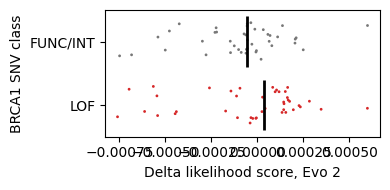

In [27]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_df,
    x='evo2_delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="evo2_delta_score",
            y="class",
            data=brca1_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method.



In [28]:
# Calculate AUROC of zero-shot predictions
#  class 1 is LOF which is the bad thing. That means we expect this to be more negative.
y_true = (brca1_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_df['evo2_delta_score'])
print(f'Zero-shot prediction AUROC: {auroc:.2}')

Zero-shot prediction AUROC: 0.4
